In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import wget
import re
import google.transit.gtfs_realtime_pb2 as gtfs
from datetime import datetime
import os
import time
import gmplot

In [2]:
def get_lines():
    routes = pd.read_csv('./rome_static_gtfs/routes.txt')
    lines = routes.route_short_name.values
    lines_numeric = []
    for line in lines:
        try:
            lines_numeric.append(int(line))
        except:
            pass
    lines_numeric = list(set(lines_numeric))
    lines_numeric.sort()
    return lines_numeric

Number of lines: 258


Text(0, 0.5, 'Line number')

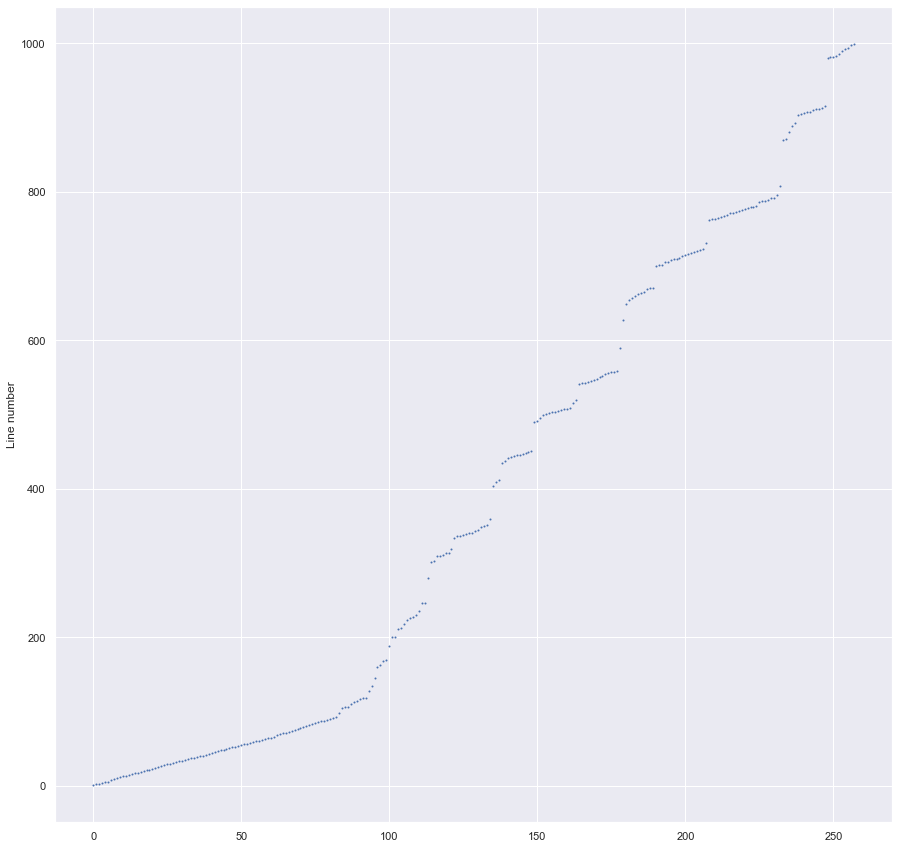

In [3]:
lines = get_lines()
print('Number of lines: {}'.format(len(lines)))
plt.figure(figsize=(15, 15))
plt.plot(lines, 'o', markersize=1)
plt.ylabel('Line number')

# Functions

In [4]:
def get_route_id(bus_num):
    routes = pd.read_csv('./rome_static_gtfs/routes.txt')
    route_id = routes[routes.route_short_name == str(bus_num)].route_id.values[0]
    return route_id

In [5]:
def get_trip_ids(route_id):
    trips = pd.read_csv('./rome_static_gtfs/trips.txt')
    trip_ids = trips[trips.route_id == route_id].trip_id.values
    return trip_ids

In [6]:
def get_scheduled_times_df(trip_ids):
    stop_times = pd.read_csv('./rome_static_gtfs/stop_times.txt')
    stop_times = stop_times[stop_times.trip_id.isin(trip_ids)].reset_index(drop=True)
    return stop_times

In [7]:
def get_line_info(df, line_num):
    durations = []
    lengths = []
    stops = []
    for trip in df.trip_id.unique():
        df_trip = df[df.trip_id == trip]
        if df_trip.shape_dist_traveled.iloc[-1] not in lengths:
            lengths.append(df_trip.shape_dist_traveled.iloc[-1])
        in_time = df_trip.arrival_time.iloc[0]
        end_time = df_trip.arrival_time.iloc[-1]
        try:
            td = str(pd.to_datetime(end_time) - pd.to_datetime(in_time)).split(' ')[-1]
            if td not in durations:
                durations.append(td)
        except:
            pass
        if len(df_trip) not in stops:
            stops.append(len(df_trip))
    print('Line number: {}'.format(line_num))
    print()
    print('Number of stops (i/o): {}'.format(stops))
    print()
    print('Number of daily trips: {}'.format(len(df.trip_id.unique())))
    print()
    print('Trip durations (i/o): {}'.format(durations))
    print()
    print('Trip lengths (i/o): {}'.format(lengths))

In [8]:
def get_line_map(line_num, route_id):
    trips = pd.read_csv('./rome_static_gtfs/trips.txt')
    shape_ids = trips[trips.route_id == route_id].shape_id.unique()
    shapes = pd.read_csv('./rome_static_gtfs/shapes.txt')
    shapes = shapes[shapes.shape_id.isin(shape_ids)]
    latitudes = {}
    longitudes = {}
    for s in shape_ids:
        df = shapes[shapes.shape_id == s]
        latitudes[s] = [df.shape_pt_lat.iloc[i] for i in range(len(df))]
        
        longitudes[s] = [df.shape_pt_lon.iloc[i] for i in range(len(df))]
    gmap = gmplot.GoogleMapPlotter(41.8875, 12.4989, 12)
    clrs = ['b', 'r', 'k', 'm', 'g']
    for i, s in enumerate(latitudes.keys()):
        gmap.plot(latitudes[s], longitudes[s], clrs[i], edge_width=5) 
    gmap.draw(str(line_num)+'_routes.html')

# Bus line

In [9]:
bus_num = 671
route_id = get_route_id(bus_num)
trip_ids = get_trip_ids(route_id)
scheduled_times = get_scheduled_times_df(trip_ids)
scheduled_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,VJ4dd9572a7ed1690a55d18e4c03baee38f38d3573,12:38:00,12:38:00,ROME797,0,NaN,0,1,0.0,1
1,VJ4dd9572a7ed1690a55d18e4c03baee38f38d3573,12:42:42,12:42:42,ROME804,1,NaN,0,0,1084.0,0
2,VJ4dd9572a7ed1690a55d18e4c03baee38f38d3573,12:43:22,12:43:22,ROME3520,2,NaN,0,0,1240.0,0
3,VJ4dd9572a7ed1690a55d18e4c03baee38f38d3573,12:44:32,12:44:32,ROME680,3,NaN,0,0,1512.0,0
4,VJ4dd9572a7ed1690a55d18e4c03baee38f38d3573,12:45:36,12:45:36,ROME2314,4,NaN,0,0,1754.0,0


In [10]:
get_line_info(scheduled_times, bus_num)

Line number: 671

Number of stops (i/o): [41, 44]

Number of daily trips: 381

Trip durations (i/o): ['01:02:00', '01:04:00', '01:15:00', '00:44:00', '01:05:00', '01:01:00', '01:06:00', '00:40:00', '00:48:00', '00:59:00', '00:55:00', '00:52:00', '01:00:00', '00:41:00', '00:42:00', '00:45:00', '00:57:00', '00:58:00', '00:49:00', '01:10:00', '00:50:00', '00:51:00', '00:54:00', '00:56:00', '00:47:00', '01:07:00', '01:19:00', '00:46:00', '01:11:00', '01:12:00', '00:43:00', '01:18:00']

Trip lengths (i/o): [14284.0, 13946.0]


In [11]:
get_line_map(bus_num, route_id)

# Download data

### Trips and positions updates

In [12]:
time_zone = 'Europe/Rome'
update_time = 30
trips_file = './bus_realtime/trips.pb'
pos_file = './bus_realtime/positions.pb'

In [ ]:
########## REPEAT EVERY DAY ##########
timestamp = 0
today = datetime.today()

csv_final = open('./bus_realtime/realtime_'+str(bus_num)+'_'+today.strftime('%Y%m%d')+'.csv', 'w')
csv_final.write('trip_id,arrival_time,departure_time,stop_id,stop_sequence\n')

csv_pos = open('./bus_realtime/positions_'+str(bus_num)+'_'+today.strftime('%Y%m%d')+'.csv', 'w')
csv_pos.write('trip_id,lat,lon,stop_sequence,stop_status,arrival_time\n')

min_hour = pd.to_datetime(today.strftime('%Y%m%d070000')).timestamp()
max_hour = pd.to_datetime(today.strftime('%Y%m%d170000')).timestamp()
now = pd.to_datetime(datetime.today().strftime('%Y%m%d%H%M%S')).timestamp()

while now >= min_hour and now <= max_hour:
    #trip updates
    try:
        wget.download('https://romamobilita.it/sites/default/files/rome_rtgtfs_trip_updates_feed.pb', trips_file)
        feed = gtfs.FeedMessage()
        with open(trips_file, 'rb') as f:
            content = f.read()
        feed.ParseFromString(content)
        if feed.header.timestamp != timestamp:
            timestamp = feed.header.timestamp
            for entity in feed.entity:
                if entity.trip_update.trip.route_id == str(route_id):
                    trip_id = entity.trip_update.trip.trip_id
                    for stop in entity.trip_update.stop_time_update:
                        try:
                            arrival_time = pd.to_datetime(stop.arrival.time,
                                                        unit='s').tz_localize('UTC').tz_convert(time_zone).strftime('%H:%M:%S')
                        except:
                            arrival_time = np.nan
                        try:
                            departure_time = pd.to_datetime(stop.departure.time,
                                                        unit='s').tz_localize('UTC').tz_convert(time_zone).strftime('%H:%M:%S')
                        except:
                            departure_time = np.nan
                        csv_final.write('{},{},{},{},{}\n'.format(trip_id, arrival_time, departure_time,
                                                                  stop.stop_id, stop.stop_sequence))
    except:
        pass
    if os.path.exists(trips_file):
        os.remove(trips_file)
    #position updates
    try:
        wget.download('https://romamobilita.it/sites/default/files/rome_rtgtfs_vehicle_positions_feed.pb', pos_file)
        feed = gtfs.FeedMessage()
        with open(pos_file, 'rb') as f:
            content = f.read()
        feed.ParseFromString(content)
        if feed.header.timestamp != timestamp:
            timestamp = feed.header.timestamp
            for entity in feed.entity:
                if entity.vehicle.trip.route_id == str(route_id):
                    trip_id = entity.vehicle.trip.trip_id
                    lat = entity.vehicle.position.latitude
                    lon = entity.vehicle.position.longitude
                    stop_seq = entity.vehicle.current_stop_sequence
                    stop_status = entity.vehicle.current_status
                    try:
                        arrival_time = pd.to_datetime(entity.vehicle.timestamp,
                                                    unit='s').tz_localize('UTC').tz_convert(time_zone).strftime('%H:%M:%S')
                    except:
                        arrival_time = np.nan
                    csv_pos.write('{},{},{},{},{},{}\n'.format(trip_id, lat, lon, stop_seq, stop_status, arrival_time))
    except:
        pass
    if os.path.exists(pos_file):
        os.remove(pos_file)
    #sleep and update current time
    time.sleep(update_time)
    now = pd.to_datetime(datetime.today().strftime('%Y%m%d%H%M%S')).timestamp()
    
csv_final.close()
csv_pos.close()